Implements Novak's *AN EXPERIMENT IN COMPUTATIONAL COMPOSITION (1989)* to create training set for 3D-GANs

In [1]:
%pylab inline

import math
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Utilities

In [2]:
# returns the "max entropy" for a list of "n" elements
def max_H(n):
    return H(np.array([1/n]*n))

In [3]:
# normalizes "prob"
def normalize(prob):
    return prob / np.sum(prob)

In [4]:
# flattens a grouped probability list
def flat(arr):
    return [i for tup in arr for i in tup]

### Scores

In [5]:
# entropy of a given list of probabilities
def H(prob):
    if not 0.99999 <= np.sum(prob) <= 1.0001:
        print("Probabilities must sum to 1.0. Use 'normalize(arr)'.")
        return 
    
    _s = 0
    for i in prob:
        if(i > 0):
            _s += i*math.log2(1.0/i)
    return _s

In [6]:
# returns visual information
#  internal VI := probabilities are selected from the same row 
#  external VI := probabilities are selected from the same column 
def VI(prob, c = None):
    if c == None:
        c = max_H(len(prob))
    return c - H(normalize(prob))

### Calculate all scores

In [7]:
# calculates "VI_int" and "VI_ext" scores from visual entity matrix "O"
# gene = gene index                        (row)
# param = [ group_index, param_index ]     (column)
def calculate_VIs(O, gene, param):
    VI_int = VI(normalize( flat(O[gene,:]) ))
    VI_ext = VI(normalize( [i[param[1]] for i in O[:,param[0]]] ))
    return VI_int, VI_ext

In [8]:
def calculate_pareto(vi_i_p, vi_e_p, vi_i, vi_e):
    c_i = vi_i - vi_i_p
    c_e = vi_e - vi_e_p
    
    if c_i < 0 or c_e < 0:
        return -1
    elif c_i > 0 or c_e > 0:
        return 1
    else:
        return 0

### Mutation method

In [9]:
# mutates the given visual entity matrix "0"
def mutate(O, ran):
    def _mut(mat, gene_index=None, index=None, value=None):
        # copy the matrix
        _O = mat.copy()

        ## choose a gene strip randomly
        if gene_index is None:
            gene_index = random.randint(0, len(_O))
        gene = _O[gene_index]

        ## choose a parameter in gene strip randomly
        if index is None:
            group_index = random.randint(0, len(gene))
            index = ( group_index, random.randint(0, len(gene[group_index])) )

        ## calculate prior VI scores
        VI_i_p, VI_e_p = calculate_VIs(_O, gene_index, index)

        ## choose a mutation value randomly
        if value is None:
            value = random.random()*ran*gene[index[0]][index[1]]

        ## choose an operation randomly (add(1), substract(-1), no_change(0))
        operation = random.choice([-1,0,1])

        ## choose one neighbor randomly and adjust its value (left(-1), right(1))
        neighbor = random.randint(0, len(gene[index[0]]))
        while neighbor == index[1]:
            neighbor = random.randint(0, len(gene[index[0]]))

        ## apply mutation to the gene
        gene[index[0]][index[1]] += operation*value
        gene[index[0]][neighbor] += -operation*value

        ## calculate VI scores
        VI_i, VI_e = calculate_VIs(_O, gene_index, index)

        ## calculate decisions
        pareto = calculate_pareto(VI_i_p, VI_e_p, VI_i, VI_e)
        
        # -1 -> pick different gene
        #  0 -> pick different mutation value
        #  1 -> accept mutation
        if pareto == -1:
            return _mut(mat)
        elif pareto == 0:
            return _mut(mat, gene_index=gene_index, index=index)
        elif pareto == 1:
            return _O
        
    try:
        return _mut(O)
    except RecursionError as re:
        print(".", end='')
        return O

### Run evolution

In [10]:
## evolve 'O' for 'n' iterations
def evolve(O, n=500, range=0.1, size=(300,300)):
    _O = O.copy()

    # run n iterations
    for _ in np.arange(n):
        # mutates the matrix
        _O = mutate(_O, range)
                
    # returns evolved matrix
    return _O

In [70]:
## evolve multiple 'O's for 'n' iterations
def evolve_all(Os, n=500, range=0.1, size=(300,300)):
    for i in np.arange(len(Os)):
        Os[i] = evolve(Os[i], n, range, size)
    return Os

### Show 2D

In [11]:
# displays composition as image
def show_comp(O, size=(400,400), legend=False):
    im = np.ones(size[:2])
    
    for rect_xy in O:
        r_x = rect_xy[0]
        r_y = rect_xy[1]
        
        sub_im = im[int(r_y[0]):int(r_y[0]+r_y[1]),
                    int(r_x[0]):int(r_x[0]+r_x[1])]
        im[int(r_y[0]):int(r_y[0]+r_y[1]),
           int(r_x[0]):int(r_x[0]+r_x[1])] = np.logical_xor(sub_im, 1).astype(int)
    
    imshow(im, cmap='gray')
    if legend is True:
        colorbar()

In [72]:
## shows multiple compositions
def show_all(Os, size=(300,300), legend=False):
    figure(figsize=(len(Os)*5, 4))
    
    for j in np.arange(len(Os)):
        plt.subplot(1, len(Os), j+1, 
                    title="({})".format(j))
        show_comp(Os[j], size=size, legend=legend)

### Show 3D

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [14]:
def create_voxel(O, size=(30,30,30), compSize=(300,300,300)):
    # create voxels
    voxels = np.zeros(size[:3])
    
    c_x, c_y, c_z = size[0]/compSize[0], size[1]/compSize[1], size[2]/compSize[2]
    
    # blocks
    for rect_xyz in O:
        r_x = rect_xyz[0]
        r_y = rect_xyz[1]
        r_z = rect_xyz[2]
        
        sub_v = voxels[int(r_z[0]*c_z):int(r_z[0]*c_z+r_z[1]*c_z),
                       int(r_y[0]*c_y):int(r_y[0]*c_y+r_y[1]*c_y),
                       int(r_x[0]*c_x):int(r_x[0]*c_x+r_x[1]*c_x)]
        voxels[int(r_z[0]*c_z):int(r_z[0]*c_z+r_z[1]*c_z),
               int(r_y[0]*c_y):int(r_y[0]*c_y+r_y[1]*c_y),
               int(r_x[0]*c_x):int(r_x[0]*c_x+r_x[1]*c_x)] = np.logical_xor(sub_v, 1).astype(int)
        
    return voxels

In [15]:
# show one composition
def show_voxel(O, size=(30,30,30), compSize=(300,300,300)):
    fig = plt.figure(figsize=(5,4))
    ax = fig.gca(projection='3d')
    ax.voxels(create_voxel(O, size=size, compSize=compSize), 
              edgecolor='k')
    plt.show()
    
# show all compositions
def show_voxels(Os, size=(30,30,30), compSize=(300,300,300)):
    fig = plt.figure(figsize=(len(Os)*5, 4))
    for i in arange(0, len(Os)):
        ax = fig.add_subplot(1,len(Os),i+1, projection='3d')
        ax.voxels(create_voxel(Os[i], size=size, compSize=compSize), 
                  edgecolor='k')
    plt.show()

### Create Matrices

In [56]:
# total size of the image (based on the contents of O)
SIZE = (300, 300)

O = np.array([[(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)]])

In [33]:
# create a composition with 'n' elements
def create_matrix(n, ndim=3, size=(300,300,300)):
    if ndim != len(size):
        print("Number of dimension and length of size doesn't match: ndim={}, size={}".format(ndim, size))
        return
    return np.ones((n, ndim, 3))*(size[0]//3)

In [68]:
# create 'm' compositions with 'n' elements
def create_matrices(m, n=40, ndim=3, size=(300,300,300)):
    Os = np.empty(m, dtype=object)
    for i in np.arange(m):
        Os[i] = create_matrix(n, ndim, size)
    return Os

### Testing

Single composition

In [64]:
SIZE = (400,400,400)
O = create_matrix(40, size=SIZE)

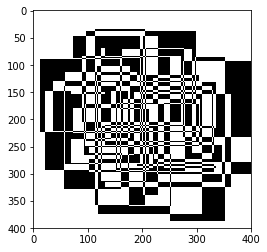

In [51]:
O = evolve(O, n=500, range=0.3, size=SIZE)
show_comp(O, size=SIZE)

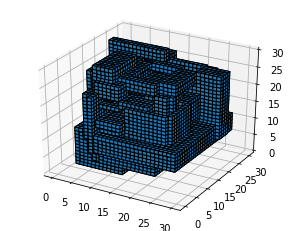

In [53]:
show_voxel(O, size=(30,30,30), compSize=SIZE)

Multiple compositions

In [69]:
SIZE = (400,400,400)
Os = create_matrices(4, 40, size=SIZE)

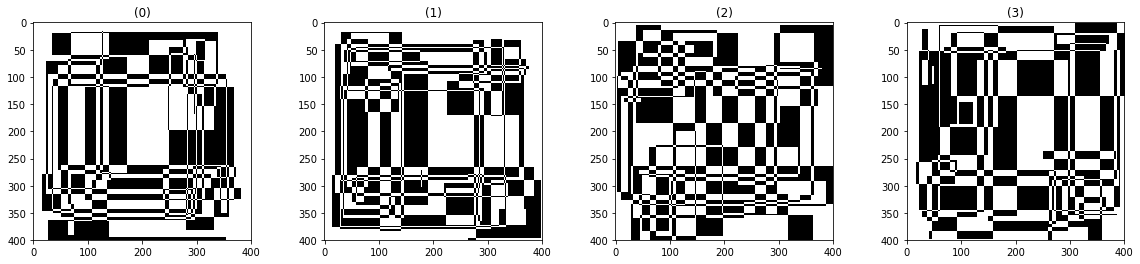

In [76]:
Os = evolve_all(Os, n=2000, range=0.1, size=SIZE)
show_all(Os, size=SIZE)

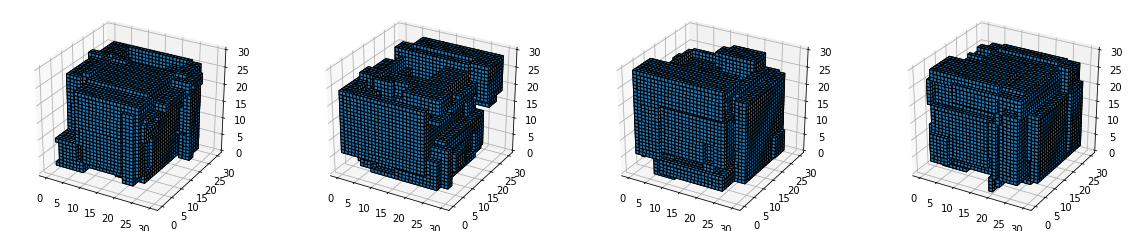

In [77]:
show_voxels(Os, size=(30,30,30), compSize=SIZE)

### .mat files

In [20]:
from scipy.io import loadmat, savemat
import datetime

In [21]:
def load_mat(name):
    fig = plt.figure(figsize=(5, 4))
    im = loadmat(name)['instance']

    ax = fig.gca(projection='3d')
    ax.voxels(im, edgecolor=matplotlib.colors.colorConverter.to_rgba('black', alpha=.1), alpha=0.5)
    plt.show()

In [22]:
def save_mat(name, O, comp=True):
    now = datetime.datetime.now()
    obj = {'__header__': str.encode('MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: ' + 
                                    now.strftime("%a %b %d %H:%M:%S %Y")),
           '__version__': '1.0',
           '__globals__': [],
           'instance': create_voxel(O, size=(30,30,30), compSize=SIZE)}

    ## write mat file
    savemat(name, obj, do_compression=comp)

#### Create the training set

In [23]:
# # total size of the image (based on the contents of O)
# SIZE = (300, 300, 300)

# N = 5000
# n = 5
# m = 8

# for i in arange(200, N//n):
#     O = np.ones((n, 6, m))*(SIZE[0]//m)
#     O[:,3:,:] = 0.5

#     O = evolve(O, n=2000, range=0.1, show=False, size=SIZE)

#     for j in arange(0, n):
#         save_mat('compositions/comp'+str(i*n+j)+'.mat', O[j])

#### Output files

In [24]:
load_mat('output/biasfree_4000.mat')

KeyboardInterrupt: 

In [ ]:
load_mat('output/biasfree_5000.mat')

In [ ]:
load_mat('output/biasfree_7000.mat')